# HWK 10: Text Processing

### Date: 4/23/2024
### Name: Ryan Jinnette
### UT EID: raj2552
### Name: Abhinav Yarlagadda
### UT EID: ay7485

This assignment will explore textual data. It will use three different texts to demonstrate different features:
  1. A classic novel, "Alice’s Adventures in Wonderland" by Lewis Carroll as our example text (avaiable via [these terms](https://www.gutenberg.org/files/11/11-h/11-h.htm))
  2. The infamous first sentence of the 1830 novel Paul Clifford by Englishman Edward Bulwer-Lytton: `It was a dark and stormy night; the rain fell in torrents—except at occasional intervals, when it was checked by a violent gust of wind which swept up the streets (for it is in London that our scene lies), rattling along the housetops, and fiercely agitating the scanty flame of the lamps that struggled against the darkness.`
  3. The Mar 19, 2021 obituary of Elsa Peretti.

## 🛒 1. Prepare

In addition to Pandas and Altair, we import the Natural Language Toolkit (in short `nltk`):

In [90]:
import pandas as pd
import altair as alt
import nltk # ← new
import requests # for fetching text documents from a url



DataTransformerRegistry.enable('vegafusion')

This time, we will also need to download a bunch of required datasets that are necessary for various text processing steps. To get this out of the way, we will do this in one go. This might take a few minutes.

In [91]:
nltk.download('punkt') # necessary for tokenization
nltk.download('wordnet') # necessary for lemmatization
nltk.download('stopwords') # necessary for removal of stop words
nltk.download('averaged_perceptron_tagger') # necessary for POS tagging
nltk.download('maxent_ne_chunker' ) # necessary for entity extraction
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
alt.data_transformers.enable("vegafusion")
# another library for text analysis
!pip install SpaCy

# and a small English language model
!python3 -m spacy download en_core_web_sm

# # this tutorial will feature a wordcloud
!pip install wordcloud

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ryanjinnette/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ryanjinnette/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryanjinnette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ryanjinnette/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/ryanjinnette/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ryanjinnette/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data] 


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### String cleaning

Before we visualize any text, we need to do some normalization. Load our novel's text

In [62]:
request = requests.get('https://gist.githubusercontent.com/isha211/5f26d62215e2c694b91baba0b5172e88/raw/4b476a84553a247efcdd96541ff86146a3cf5964/alice.txt')
#story = request.text

with open('emily_watson_odyssey.txt', 'r') as f:
    story = f.read()

# display first 500 characters
print(story[:500]+"...")

W. W. NORTON & COMPANY, INC.
Independent Publishers Since 1923
New York * London
OceanofPDF.com

HOMER
THE
ODYSSEY

TRANSLATED BY EMILY WILSON
OceanofPDF.com

Adjusting type size may change line breaks. Landscape mode may help to
preserve line breaks.
OceanofPDF.com

To my daughters,
Imogen, Psyche, and Freya
OceanofPDF.com

CONTENTS

INTRODUCTION
TRANSLATOR’S NOTE
MAPS

1. The World of The Odyssey
2. The Aegean and Asia Minor
3. Mainland Greece
4. The Peloponnese

THE ODYSSEY
The Boy and th...


At this point the entire story is loaded into one long string.

💡 *Examine the character length of the story and look at the current state of the memory in the kernel:*

In [63]:
print(len(story))
%whos

720273
Variable            Type                    Data/Info
-----------------------------------------------------
WordCloud           type                    <class 'wordcloud.wordcloud.WordCloud'>
alt                 module                  <module 'altair' from '/L<...>ages/altair/__init__.py'>
base                Chart                   alt.Chart(...)
bow                 dict                    n=2309
chart1              Chart                   alt.Chart(...)
chart2              Chart                   alt.Chart(...)
clear_output        function                <function clear_output at 0x104ec07c0>
df                  DataFrame                             word       <...>n[11656 rows x 2 columns]
df_pared            DataFrame                        word    type\n0 <...>\n[4798 rows x 2 columns]
df_top              DataFrame                      word  count\n0    <...>   55\n19   hatter     55
df_top_100          DataFrame                     word  count\n0     <...>n\n[100 rows x 2

### Tokenization

Tokenization is the process of turning a text into chunks that we can more easily work with. Typically tokenization refers to the separation and extraction of words. This process largely relies on the use of spaces and punctuation marks. The latter are typically included as tokens themselves.

Suppose we have a sentence such as this one:

In [64]:
sentence = "It was a dark and stormy night; the rain fell in torrents—except at occasional intervals, when it was checked by a violent gust of wind which swept up the streets (for it is in London that our scene lies), rattling along the housetops, and fiercely agitating the scanty flame of the lamps that struggled against the darkness."

Now, with nltk's `word_tokenize()` we can extract all tokens into a neat list:

In [65]:
words = nltk.word_tokenize(sentence)
words

['It',
 'was',
 'a',
 'dark',
 'and',
 'stormy',
 'night',
 ';',
 'the',
 'rain',
 'fell',
 'in',
 'torrents—except',
 'at',
 'occasional',
 'intervals',
 ',',
 'when',
 'it',
 'was',
 'checked',
 'by',
 'a',
 'violent',
 'gust',
 'of',
 'wind',
 'which',
 'swept',
 'up',
 'the',
 'streets',
 '(',
 'for',
 'it',
 'is',
 'in',
 'London',
 'that',
 'our',
 'scene',
 'lies',
 ')',
 ',',
 'rattling',
 'along',
 'the',
 'housetops',
 ',',
 'and',
 'fiercely',
 'agitating',
 'the',
 'scanty',
 'flame',
 'of',
 'the',
 'lamps',
 'that',
 'struggled',
 'against',
 'the',
 'darkness',
 '.']

As you can see we also get the punctuation marks. These we can avoid with a different kind of tokenizer (e.g., the RegexpTokenizer) or by simply removing non-letter strings with Python's `isalpha()` method. This removes any token containing something else but letters, so if you expect that there are numbers, or embedded non-alpha characters, in your text you'll need to consider those seperately or use another method).

In [66]:
# the list comprehension is extracting only words that contain exclusively letters.
onlywords = [word for word in words if word.isalpha()]

onlywords[0:20]

['It',
 'was',
 'a',
 'dark',
 'and',
 'stormy',
 'night',
 'the',
 'rain',
 'fell',
 'in',
 'at',
 'occasional',
 'intervals',
 'when',
 'it',
 'was',
 'checked',
 'by',
 'a']

Sometimes capitialization can change the mearning of the word, but for a broadstrokes natural language processing word cloud, we can remove capitialization to reduce the number of unique words in our dataset.

In [67]:
lowerwords = [word.lower() for word in onlywords]
lowerwords[0:10]

['it', 'was', 'a', 'dark', 'and', 'stormy', 'night', 'the', 'rain', 'fell']

### Stemming & lemmatizing

Words are often inflected to indicate plural, tense, case, etc. To get the word stem or lemma, you can apply stemming or lemmatization. The **stemmer** operates on a relatively robust, but simplistic rule set.  In contrast, lemmatization is more reliable in the linking different word variants of the same dictionary entry of the same word, a.k.a. lemma, but it's computationally more expensive.

Let's compare them both:

In [68]:
from nltk.stem import PorterStemmer as stemmer
from nltk.stem import WordNetLemmatizer as lemmatizer
from nltk.corpus import wordnet # for robust lemmatization

word = "said"

print(stemmer().stem(word))
print(lemmatizer().lemmatize(word, pos = wordnet.VERB))

said
say


To lemmatize we needed to indicate the word type via the second parameter `pos`. But how do we know that it's a verb?

### Part-of-speech tagging

Words assume specific roles in sentences. POS tagging identifies these roles as the parts of speech, which roughly translates to word categories such as verbs, nouns, adjectives etc.

To do POS tagging with NLTK, we need to first run the tokenization. So let's revisit the sentence from above:

In [69]:
# to save us some typing, we import these, so we can call them directly
from nltk import word_tokenize, pos_tag

# first we tokenize then we pos_tag
sentence = pos_tag(word_tokenize(sentence))

sentence

[('It', 'PRP'),
 ('was', 'VBD'),
 ('a', 'DT'),
 ('dark', 'NN'),
 ('and', 'CC'),
 ('stormy', 'NN'),
 ('night', 'NN'),
 (';', ':'),
 ('the', 'DT'),
 ('rain', 'NN'),
 ('fell', 'VBD'),
 ('in', 'IN'),
 ('torrents—except', 'NN'),
 ('at', 'IN'),
 ('occasional', 'JJ'),
 ('intervals', 'NNS'),
 (',', ','),
 ('when', 'WRB'),
 ('it', 'PRP'),
 ('was', 'VBD'),
 ('checked', 'VBN'),
 ('by', 'IN'),
 ('a', 'DT'),
 ('violent', 'JJ'),
 ('gust', 'NN'),
 ('of', 'IN'),
 ('wind', 'NN'),
 ('which', 'WDT'),
 ('swept', 'VBD'),
 ('up', 'RP'),
 ('the', 'DT'),
 ('streets', 'NNS'),
 ('(', '('),
 ('for', 'IN'),
 ('it', 'PRP'),
 ('is', 'VBZ'),
 ('in', 'IN'),
 ('London', 'NNP'),
 ('that', 'IN'),
 ('our', 'PRP$'),
 ('scene', 'NN'),
 ('lies', 'VBZ'),
 (')', ')'),
 (',', ','),
 ('rattling', 'VBG'),
 ('along', 'IN'),
 ('the', 'DT'),
 ('housetops', 'NNS'),
 (',', ','),
 ('and', 'CC'),
 ('fiercely', 'RB'),
 ('agitating', 'VBG'),
 ('the', 'DT'),
 ('scanty', 'NN'),
 ('flame', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('lamps', 'N

This gives us a list of tuples, each of which contains the token again, plus the part of speech encoded in a tag. There is actually a good overview of the POS tags with brief definitions and examples [on Stack Overflow](https://stackoverflow.com/a/38264311).

Again, let's go back to our full story, and extract the word from Alice, lemmatizing just the verbs:

In [70]:
# same as above: first tokenize, then pos_tag
pos = pos_tag(word_tokenize(story))

# to keep things short & sweet, we define a function for lemmatizing verbs
def lemmatize_verb (word):
  return lemmatizer().lemmatize(word.lower(), pos = wordnet.VERB)

# remember this form? the condition matches verbs, whose POS tag starts with a V
verbs = [lemmatize_verb(word[0]) for word in pos if word[1][0]=="V"]

# let's look at the first 50 verbs
print(verbs[:50])

['change', 'help', 'preserve', 'book', 'change', 'help', 'preserve', 'be', 'be', 'be', 'present', 'tell', 'use', 'sing', 'be', 'mislead', 'turn', 'begin', 'mean', '“', 'be', 'relate', 'say', '“', 'tell', 'be', 'use', 'command', '”', 'be', 'be', 'tell', 'be', '“', 'be', 'be', 'elevate', 'compose', 'be', 'use', 'contain', 'associate', 'be', 'be', 'be', 'speak', 'be', 'be', 'mark', 's']


Woot! We just extracted all verbs from a story and normalized them! Awesome-sauce.
Repeating the last step for nouns, we'll need to specify `lemmatize_noun()` and apply that

In [71]:
# to keep things short & sweet, we define a function for lemmatizing verbs
def lemmatize_noun (word):
  return lemmatizer().lemmatize(word.lower(), pos = wordnet.NOUN)

# remember this form? the condition matches verbs, whose POS tag starts with a V
nouns = [lemmatize_noun(word[0]) for word in pos if word[1][0]=="N"]

# let's look at the first 50 nouns
print(nouns[:50])

['w.', 'w.', 'norton', 'company', 'inc', 'independent', 'publisher', 'new', 'york', '*', 'london', 'oceanofpdf.com', 'homer', 'the', 'odyssey', 'translated', 'by', 'emily', 'wilson', 'oceanofpdf.com', 'adjusting', 'type', 'size', 'line', 'break', 'landscape', 'mode', 'line', 'break', 'oceanofpdf.com', 'daughter', 'imogen', 'psyche', 'freya', 'oceanofpdf.com', 'content', 'introduction', 'translator', '’', 's', 'note', 'map', 'world', 'odyssey', 'aegean', 'asia', 'minor', 'mainland', 'greece', 'peloponnese']


## 📄 2. Process

Now we can turn a text into its components and distinguish these tokens as different word types. Let's proceed by extracting entities, removing irrelevant words, and finding the most frequent words.

### Extract entity types

Apart from identifying word types, we can distinguish between different entities that are mentioned in a text, such as persons, places, organizations, etc. This kind of text processing is also referred to as **Named Entity Recognition** (NER).

For this step, we are straying from NLTK and use spaCy's statistical models on the English language. So first we import spaCy and load the English language model:



In [72]:
import spacy
nlp = spacy.load("en_core_web_sm")

Let's find the named entities from Alice:

In [73]:
# carry out NLP processing
doc = nlp(story)

# get each the text and entity label of all word entities in the article
entities = [ (e.text, e.label_) for e in doc.ents if e.text ]

# see first 20 entities
entities[0:20]

[('W. W. NORTON & COMPANY', 'PERSON'),
 ('Independent Publishers', 'ORG'),
 ('1923', 'DATE'),
 ('New York', 'GPE'),
 ('London', 'GPE'),
 ('HOMER', 'ORG'),
 ('ODYSSEY', 'ORG'),
 ('EMILY WILSON', 'PERSON'),
 ('Imogen', 'GPE'),
 ('Psyche', 'ORG'),
 ('Freya', 'PERSON'),
 ('MAPS', 'ORG'),
 ('1', 'CARDINAL'),
 ('The World of The Odyssey', 'WORK_OF_ART'),
 ('2', 'CARDINAL'),
 ('Aegean', 'NORP'),
 ('Asia Minor', 'LOC'),
 ('3', 'CARDINAL'),
 ('Greece', 'GPE'),
 ('4', 'CARDINAL')]

Now all tokens that have been recognized as particular entities are extracted and associated with an entity type. Have a look at spaCy's [overview of NER tags](https://spacy.io/api/annotation#named-entities) to understand what they refer to.  These types of parts of speach taggers are typically trained on news stories.  You can see that the results are questionable for our novel.

### Remove stop words

The opposite of particularly interesting entitites are so-called stop words. They are very common and serve as short function words such as "the", "is", "or", "at". In text processing it can be useful to remove these frequent words to focus on those terms that are more specific to a given document.

NLTK actually already includes stop words for several languages, including English.  I'm going to add the word "chapter" to the stop list for this case, since that is a visual que for the reader, not a integral part of the story.

In [74]:
from nltk.corpus import stopwords as stop

stopwords = stop.words("english")

stopwords.append('chapter')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

As a next step we remove the stop words from the short story to focus on those words that carry meaning:

In [75]:
tokens = nltk.word_tokenize(story.lower())

# let's focus on those tokens that contain only letters
words = [word for word in tokens if word.isalpha()]

# this is a special form called List Comprehensions
without_stopwords = [word for word in words if word not in stopwords]

print(without_stopwords[:50])

['norton', 'company', 'independent', 'publishers', 'since', 'new', 'york', 'london', 'homer', 'odyssey', 'translated', 'emily', 'wilson', 'adjusting', 'type', 'size', 'may', 'change', 'line', 'breaks', 'landscape', 'mode', 'may', 'help', 'preserve', 'line', 'breaks', 'daughters', 'imogen', 'psyche', 'freya', 'contents', 'introduction', 'translator', 'note', 'maps', 'world', 'odyssey', 'aegean', 'asia', 'minor', 'mainland', 'greece', 'peloponnese', 'odyssey', 'boy', 'goddess', 'book', 'dangerous', 'journey']


### Pack a bag of words

A common representation of text documents is the bag-of-words model, which simply considers a given text as a set of words, disregarding sentence or document structure. Typically, a bag-of-words representation is combined with the frequency of words in a document. I'm also going to use the text with the stop words removed, assuming that they aren't interesting to me.

In [76]:
# bag of words as a dictionary data type
bow = {}

# we count the occurrences of each word and save it
for word in without_stopwords:
  bow[word] = words.count(word)

# for later use, we create a sorted list of word-frequency tuples
words_frequency = sorted(bow.items(), key=lambda x: x[1], reverse=True)

print(words_frequency[0:100])

[('odysseus', 821), ('home', 419), ('would', 390), ('men', 375), ('back', 342), ('man', 329), ('one', 309), ('gods', 301), ('suitors', 290), ('said', 289), ('house', 286), ('son', 283), ('us', 281), ('like', 272), ('telemachus', 267), ('come', 261), ('go', 256), ('father', 251), ('zeus', 251), ('ship', 221), ('went', 210), ('made', 209), ('sea', 206), ('tell', 203), ('may', 199), ('people', 195), ('god', 192), ('athena', 190), ('must', 180), ('let', 177), ('many', 175), ('old', 168), ('even', 166), ('inside', 166), ('could', 165), ('penelope', 165), ('came', 165), ('see', 161), ('told', 156), ('away', 153), ('took', 145), ('long', 144), ('king', 143), ('beside', 142), ('also', 141), ('make', 141), ('heart', 140), ('wine', 138), ('since', 136), ('brought', 135), ('across', 133), ('wife', 133), ('set', 133), ('goddess', 131), ('take', 130), ('know', 130), ('around', 129), ('good', 128), ('great', 127), ('gave', 126), ('first', 125), ('give', 124), ('ithaca', 122), ('still', 122), ('odyss

## 🥗 3. Present

Now let's turn all these words into visualizations!

### Word cloud

For text visualization, one technique has reached a lot of attention, despite its limited perceptual and analytical qualities. The word cloud (a.k.a. tag cloud) emerged in the golden age of Web 2.0 (the 2000s) and probably succeeded due to its simplicity in terms of interpretation and implementation: the more frequent a word, the larger the font size. Altair itself actually does not support word clouds, so we resort to a specific `wordcloud` generator and use `matplotlib` to render the images. The wordcloud library is extra convenient, it just takes the raw text as input:


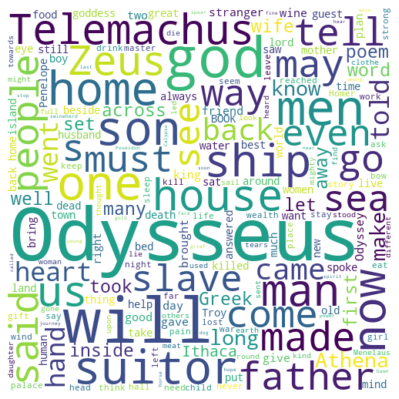

In [77]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = story
wc = WordCloud(width=500, height=500, background_color="white").generate(text)

# display the generated image:
my_dpi = 72
plt.figure(figsize = (500/my_dpi, 500/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

💡 *The word cloud library actually gives a lot of options for [customization](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud). You can change the colors, fonts, sizes, and keep the stopwords*

### Common words

We shall move on to more precise representations of text. For this we will revisit an arguably mundane, but quite effective visualization technique: we draw a barchart of the most frequent words (excluding the stop words, if you have done the pencil activity in the section on packing a bag of words).

In [78]:
# first we create a dataframe from the word frequencies
df = pd.DataFrame(words_frequency, columns=['word', 'count'])

# we want to focus just on the top 20 words
df_top = df[:20]
df_top_100 = df[:100] # use this later

# draw horizontal barchart
alt.Chart(df_top).mark_bar().encode(
  x = 'count:Q',
  y = alt.Y('word:N', sort = '-x')
)

alt.Chart(...)

### All words by type

Through POS tagging we are able to identify the different word types, such as nouns, verbs, adjectives, adverbs, and several others. So let's do exactly this and distinguish between these common word types for the story:

In [79]:
# first we extract all words and their types (a.k.a. parts-of-speech or POS)
pos = pos_tag(word_tokenize(story))

# we will be collecting words and types in lists of the same length
words = []
types = []

# iterate over all entries in the pos list (generated above)
for p in pos:
  # get the word and turn it into lowercase
  word = p[0].lower()
  # get the word's type
  tag = p[1]

  # for this analysis we remove entries that contain punctuation or numbers
  # and we also ignore the stopwords (sorry: the, and, or, etc!)
  if word.isalpha() and word not in stopwords:
    # first we add this word to the words list
    words.append(word)
    # then we add its word type to types list, based on the 1st letter of the pos tag
    # note that we access letters in a string, like entries in a list
    if   (tag[0]=="J"): types.append("Adjective")
    elif (tag[0]=="N"): types.append("Noun")
    elif (tag[0]=="R"): types.append("Adverb")
    elif (tag[0]=="V"): types.append("Verb")
    # there are many more word types, we simply subsume them under 'other'
    else: types.append("Other")

💡 *This is a good point to check what we generated. Take a look at the two lists we created:*

In [80]:
words[0:10]

['norton',
 'company',
 'inc',
 'independent',
 'publishers',
 'since',
 'new',
 'york',
 'london',
 'homer']

In [81]:
types[0:10]

['Noun',
 'Noun',
 'Noun',
 'Noun',
 'Noun',
 'Other',
 'Noun',
 'Noun',
 'Noun',
 'Noun']

With this information, we can now create two coordinated charts: one representing the frequency of the different word types and the other displaying the frequency of all words (given the current selection). But first things first: we need to create a dataframe with only the most popular 100 words by frequency.

In [82]:
# with the two lists of the same length, we create a dataframe with a dictionary,
# of which the keys will become the column labels
df = pd.DataFrame({"word": words, "type": types })

# Filter out only the top 100 words by frequency
index = df['word'].isin(df_top_100['word'])
df_pared = df[index].reset_index(drop=True)
len(df_pared)

16946

In [92]:
# along the type column, we want to support a filter selection
selection = alt.selection(type="multi", fields=['type'])

# we create a composite chart consisting of two sub-charts
# the base holds it together and acts as the concierge taking care of the data
base = alt.Chart(df_pared)

# this shows the types, note that we rely on Altair's aggregation prowess
chart1 = base.mark_bar().encode(
  x = alt.Y('type:N'),
  y = alt.X('count()'),
  # when a bar is selected, the others are displayed with reduced opacity
  opacity=alt.condition(selection, alt.value(1), alt.value(.25)),
).add_selection(selection)

# this chart reacts to the selection made in the left/above chart
chart2 = base.mark_bar(width=5).encode(
  x = 'word:N',
  y = alt.Y('count()'),
).transform_filter(selection)

chart1 | chart2

alt.HConcatChart(...)

### Keyword in context

Last but not least, it can be quite gratifying to see words in their original context. KWIC is a tried and tested method just for that purpose. Let's build one from scratch!

In [84]:
import re # regular expressions, we will need them to search through the text
# the following we need, to display a text input field and make it interactive
import ipywidgets as widgets
from IPython.display import display, clear_output

# we move all line breaks with spaces, to not mess up the display (you'll see)
text = story.replace("\n", " ")

# create a search box …
search_box = widgets.Text(placeholder='Enter search term', description='Search:')
# … and make it appear
display(search_box)

# this function is triggered when a search query is entered
def f(sender):
  # we get the query's text value
  query = search_box.value

  # this is the window of characters displayed both sides
  span = 40 - int(len(query)/2)

  # for subsequent queries, we clear the output
  clear_output(wait=True)
  # which also removes the search box, so we return it
  display(search_box)

  # when the query is too short, we do not proceed and warn the user/reader
  if (len(query)<2):
    print("\nPlease enter a longer query\n")
    return

  # and find all the start positions of matches in the text
  starts = [m.start() for m in re.finditer(query, text)]

  # if there are no matches, we also tell the user/reader
  if (len(starts)==0):
    print("\nSorry, but there are no matches for your query\n")
    return

  # we go through all the start positions
  for start in starts:
    # determine the end position, based on the query's length
    end = start+len(query)

    # we get the string left and right of the match
    # rjust returns a right-justified string, if there are few letters left of match
    left = text[max(0, start-span):start].rjust(span)
    match = text[start:end]
    right = text[end:end+span]

    # we print left and right context with the actual match in the middle
    print(left+match+right)

# the function f is linked with searchbox' on_submit event
search_box.on_submit(f)

Text(value='', description='Search:', placeholder='Enter search term')

/var/folders/f3/p47z8bv91fz_xq2tl0xv0sq80000gn/T/ipykernel_20769/3566852591.py:55: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  search_box.on_submit(f)


Try searching for `Alice` or `Rabbit`!

## Your Turn

  1. Find all of the named entities in the file `elsa_peretti_obit.txt`. Do any of the classifications seem wrong to you? Why or why not?
  2. From the `elsa_peretti_obit.txt` text file, create a horizonal bar chart of word frequencies as we did above, but sort it by values. [This example will help](https://altair-viz.github.io/gallery/bar_chart_sorted.html)
  3. Re-create the interactive graph with word type frequencies and word frequencies by selection from the tutorial, except this time use the `elsa_peretti_obit.txt` text file instead of the Alice in Wonderland text file. Sort the word frequencies from highest on left to lowest on the right.
  4. Crete a different word cloud for Alice's story, in the shape of Alice and the white rabbit.  We provided a mask, `alice_mask.png`. [This documentation](https://amueller.github.io/word_cloud/auto_examples/masked.html) will help.

In [85]:
request = requests.get('https://gist.githubusercontent.com/isha211/f1ce8a7020230205099399f7dc8edb30/raw/dfda5a993eaec33fdc4dd839556dfaab41abdaf7/elsa_peretti_obit.txt')
obit_text = request.text

In [86]:
# Question 1
# carry out NLP processing

# get the text and entity label of all word entities in the article

# print the entity classifications


➡️ YOUR ANSWER HERE: Do any of the classifications seem wrong to you? Why or why not? ⬅️

In [87]:
# Question 2
# read in the text file

# get tokens which contain letters and are longer than two characters

# remove stopwords

# pack a bag of words and get word-frequency tuples

# draw a sorted, horizontal barchart for the top 20 most frequent words

In [88]:
# Question 3
# refer to the tutorial for how to extract word types for the obituary

# get only the top 100 words of the obituary by frequency

# refer to the interactive chart in the tutorial to build a similar chart here

In [89]:
# Question 4

## Sources

Tutorials
- [A Complete Exploratory Data Analysis and Visualization for Text Data](https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a)
- [Named Entity Recognition with NLTK and SpaCy](https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da)
- [What are all possible pos tags of NLTK? - Stack Overflow](https://stackoverflow.com/a/38264311)

Documentation
- [Natural Language Toolkit — NLTK 3.5 documentation](https://www.nltk.org)
- [spaCy API Documentation - Architecture](https://spacy.io/api)
- [WordCloud for Python documentation](https://amueller.github.io/word_cloud/)

